In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
import numpy as np
import altair as alt
import pandas as pd

from scipy.sparse import lil_matrix
from annoy import AnnoyIndex
from collections import defaultdict

from sklearn.decomposition import TruncatedSVD
from sklearn import manifold
from sklearn.decomposition import PCA

from sqlalchemy.dialects.postgresql import array_agg
from sqlalchemy.sql import functions as func

from osp_graphs.v1_db import session, Text, Field, Subfield, SubfieldDocument, Citation, Document

In [3]:
count = func.count(Citation.text_id)

res = (session
    .query(Text.surname, array_agg(Citation.document_id))
    .join(Citation)
    .filter(Text.valid==True)
    .filter(Text.display==True)
    .group_by(Text.id)
    .order_by(count.desc())
    .limit(1000)
    .all())

In [4]:
surname_docs = defaultdict(set)

for surname, doc_ids in res:
    key = surname.strip('.,').lower()
    surname_docs[key].update(doc_ids)

In [5]:
surnames = sorted(surname_docs.keys())
surname_to_idx = {s: i for i, s in enumerate(surnames)}

In [6]:
doc_ids = list(set([did for _, doc_ids in res for did in doc_ids]))
doc_id_to_idx = {did: i for i, did in enumerate(doc_ids)}

In [7]:
sdm = np.zeros((len(doc_ids), len(surnames)))

for surname in surnames:
    sidx = surname_to_idx[surname]
    for doc_id in surname_docs[surname]:
        didx = doc_id_to_idx[doc_id]
        sdm[didx][sidx] += 1

In [8]:
sdm.sum()

495788.0

In [9]:
svd = TruncatedSVD(n_components=10)

In [10]:
svd.fit(sdm)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5,
       random_state=None, tol=0.0)

In [11]:
svd.components_.T.shape

(642, 10)

In [12]:
idx = AnnoyIndex(10)
for i, v in enumerate(svd.components_.T):
    idx.add_item(i, v)
    
idx.build(10)

True

In [13]:
for aidx in idx.get_nns_by_item(surname_to_idx['hemingway'], 20):
    print(surnames[aidx])

hemingway
hurston
larsen
pynchon
salinger
wharton
fitzgerald
cather
erdrich
toomer
wright
plath
herr
silko
kerouac
ellison
delillo
chopin
cisneros
chandler


In [14]:
dr = manifold.TSNE(n_components=2, init='pca')

In [15]:
y = dr.fit_transform(svd.components_.T)

In [28]:
rows = []
for surname, (x, y) in zip(surnames, y):
    rows.append(dict(surname=surname, x=x, y=y))

In [29]:
df = pd.DataFrame(rows)

In [37]:
alt.Chart(df).mark_circle().encode(x='x', y='y', tooltip='surname').interactive?

Object `interactive` not found.


In [46]:
chart = alt.Chart(df, width=1000, height=700).mark_circle().encode(x='x', y='y', tooltip='surname')

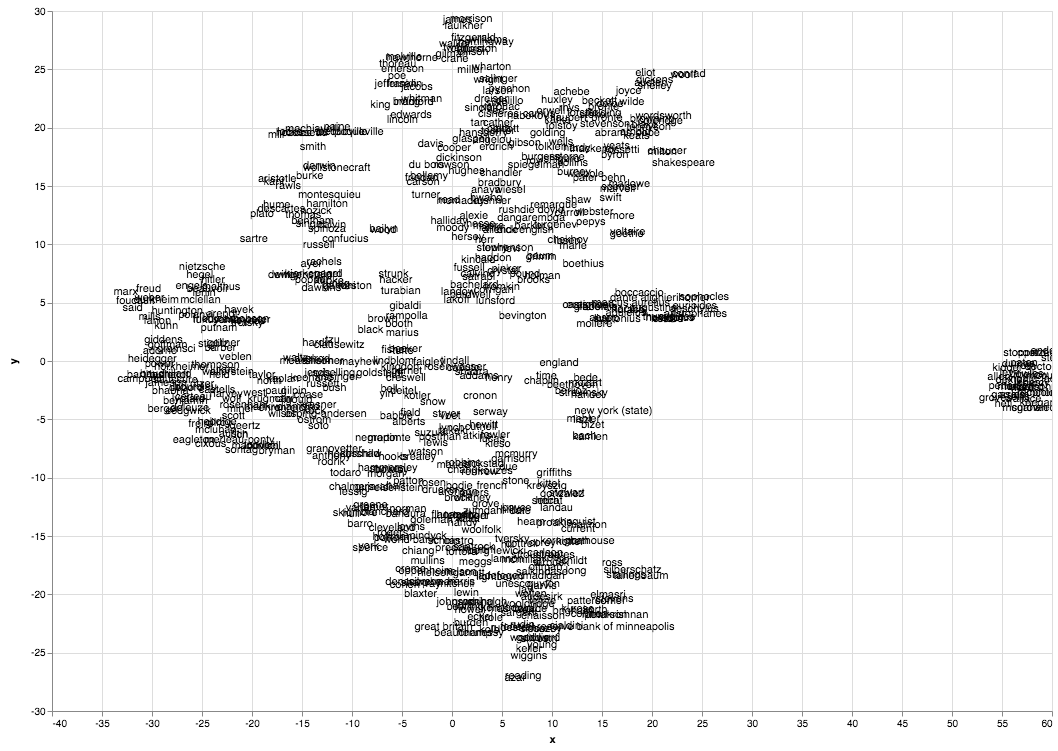

In [49]:
chart.mark_text(align='left', dx=0, dy=0).encode(text='surname')